In [1]:
# Step 1: Upload and Convert PDF Datasets in Colab
# Install necessary modules
!pip install pandas pymupdf

from google.colab import files
import pandas as pd
import fitz  # PyMuPDF for PDF text extraction

# 📤 Upload 'Publishable' PDF Dataset
print("📤 Upload the 'Publishable' PDF Dataset:")
uploaded_publishable = files.upload()
publishable_pdf_files = list(uploaded_publishable.keys())

# 📤 Upload 'Non-Publishable' PDF Dataset
print("\n📤 Upload the 'Non-Publishable' PDF Dataset:")
uploaded_non_publishable = files.upload()
non_publishable_pdf_files = list(uploaded_non_publishable.keys())

# Function to extract text from PDFs
def extract_text_from_pdfs(pdf_files):
    extracted_data = []
    for pdf_file in pdf_files:
        doc = fitz.open(pdf_file)
        text = ""
        for page in doc:
            text += page.get_text()
        extracted_data.append({"filename": pdf_file, "content": text})
    return extracted_data

# Extract text from 'Publishable' PDFs
publishable_data = extract_text_from_pdfs(publishable_pdf_files)
df_publishable = pd.DataFrame(publishable_data)
df_publishable['label'] = 'Publishable'

# Extract text from 'Non-Publishable' PDFs
non_publishable_data = extract_text_from_pdfs(non_publishable_pdf_files)
df_non_publishable = pd.DataFrame(non_publishable_data)
df_non_publishable['label'] = 'Non-Publishable'

# Combine Publishable and Non-Publishable datasets
df_train = pd.concat([df_publishable, df_non_publishable], ignore_index=True)

# Save as CSV
merged_csv_path = '/content/merged_training_dataset.csv'
df_train.to_csv(merged_csv_path, index=False)
print(f"✅ Combined training dataset saved to {merged_csv_path}")

# Display the first few rows
print("\n📝 Combined Training Dataset Overview (First 5 rows):")
print(df_train.head())

# Enable download of the merged dataset
from google.colab import files

print("\n📥 Click below to download the merged training dataset:")
files.download(merged_csv_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 25.5 MB/s eta 0:00:00
📤 Upload the 'Publishable' PDF Dataset:


Saving R006.pdf to R006.pdf
Saving R007.pdf to R007.pdf
Saving R008.pdf to R008.pdf
Saving R009.pdf to R009.pdf
Saving R010.pdf to R010.pdf
Saving R011.pdf to R011.pdf
Saving R012.pdf to R012.pdf
Saving R013.pdf to R013.pdf
Saving R014.pdf to R014.pdf
Saving R015.pdf to R015.pdf

📤 Upload the 'Non-Publishable' PDF Dataset:


Saving R001.pdf to R001.pdf
Saving R002.pdf to R002.pdf
Saving R003.pdf to R003.pdf
Saving R004.pdf to R004.pdf
Saving R005.pdf to R005.pdf
✅ Combined training dataset saved to /content/merged_training_dataset.csv

📝 Combined Training Dataset Overview (First 5 rows):
   filename                                            content        label
0  R006.pdf  Detailed Action Identification in Baseball Gam...  Publishable
1  R007.pdf  Advancements in 3D Food Modeling: A Review of ...  Publishable
2  R008.pdf  Advanced techniques for through and contextual...  Publishable
3  R009.pdf  The Importance of Written Explanations in\nAgg...  Publishable
4  R010.pdf  Detecting Medication Usage in Parkinson’s Dise...  Publishable

📥 Click below to download the merged training dataset:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install necessary libraries
!pip install pandas nltk


In [ ]:
# Import necessary libraries for preprocessing
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def preprocess_text(text):
    if pd.isna(text):
        return ""  # Handle NaN entries gracefully

    # Lowercase text
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

# Apply text preprocessing
df_train['content'] = df_train['content'].apply(preprocess_text)

# Handle missing values
df_train.dropna(subset=['content', 'label'], inplace=True)

print("\n✅ Text Preprocessing Completed.")
print("\n📝 First 5 rows after preprocessing:")
print(df_train.head())


In [ ]:
# Save the preprocessed dataset
preprocessed_csv_path = '/content/preprocessed_training_dataset.csv'
df_train.to_csv(preprocessed_csv_path, index=False)
print(f"✅ Preprocessed training dataset saved to {preprocessed_csv_path}")

# Enable download of the preprocessed dataset
from google.colab import files

print("\n📥 Click below to download the preprocessed training dataset:")
files.download(preprocessed_csv_path)


In [ ]:
# Install necessary packages
!pip install transformers pandas torch


In [ ]:
# Step 3: Feature Engineering with BERT Embeddings

import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

# Load preprocessed dataset
preprocessed_csv_path = '/content/preprocessed_training_dataset.csv'
df_train = pd.read_csv(preprocessed_csv_path)

# Verify dataset structure
print("\n✅ Dataset loaded for Feature Engineering with BERT.")
print("\n📝 First 5 rows of the dataset:")
print(df_train.head())

# Check for required columns
if 'content' not in df_train.columns or 'label' not in df_train.columns:
    raise ValueError("Dataset must have 'content' and 'label' columns!")

# Encode labels
df_train['label'] = df_train['label'].map({'Publishable': 1, 'Non-Publishable': 0})

# ✅ Load BERT Model and Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"\n✅ Using device: {device}")

# ✅ Function to extract BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output.squeeze().cpu().numpy()

# Apply BERT embeddings to the dataset
print("\n⚙️ Generating BERT embeddings (this may take time)...")
bert_embeddings = df_train['content'].apply(get_bert_embedding)

# Convert embeddings to a feature matrix
X = torch.stack([torch.tensor(embed) for embed in bert_embeddings]).numpy()
y = df_train['label'].values

print("\n✅ BERT embeddings successfully generated.")
print(f"Feature Matrix Shape: {X.shape}")

# ✅ Split Dataset into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✅ Dataset Split:")
print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")


In [ ]:
# Install necessary libraries
!pip install transformers torch


In [ ]:
# Step 4: Train Transformer-Based Model for Publishability Classification

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# ✅ Load Preprocessed Dataset
preprocessed_csv_path = '/content/preprocessed_training_dataset.csv'
df_train = pd.read_csv(preprocessed_csv_path)

# Verify dataset structure
print("\n✅ Dataset loaded for Transformer-based Training.")
print(df_train.head())

# ✅ Encode Labels
df_train['label'] = df_train['label'].map({'Publishable': 1, 'Non-Publishable': 0})

# ✅ Split Data into Training and Validation Sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_train['content'].tolist(),
    df_train['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']
)

# ✅ Tokenize Data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt'
)
val_encodings = tokenizer(
    val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt'
)

# ✅ Create a Custom Dataset Class
class PublishabilityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PublishabilityDataset(train_encodings, train_labels)
val_dataset = PublishabilityDataset(val_encodings, val_labels)

# ✅ Load Pre-trained Transformer Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f"\n✅ Using device: {device}")

# ✅ Define Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# ✅ Training Loop
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, device, epochs=12):
    model.train()
    for epoch in range(epochs):
        print(f'\n🔄 Epoch {epoch + 1}/{epochs}')
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item())

# ✅ Start Training
train_model(model, train_loader, val_loader, optimizer, device)

# ✅ Evaluation Loop
def evaluate_model(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)

    print("\n📊 Evaluation Metrics:")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")

# ✅ Evaluate the Model
evaluate_model(model, val_loader, device)

# ✅ Save the Trained Model
model_save_path = '/content/publishability_transformer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"\n✅ Transformer model saved to {model_save_path}")

# ✅ Download the Model
from google.colab import files

print("\n📥 Click below to download the trained Transformer model:")
files.download(model_save_path)


In [ ]:
# Step 5: Evaluate Transformer Model on Validation Set

import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd

# ✅ Load Validation Dataset
print("\n✅ Using the prepared validation dataset for evaluation.")
print(f"Validation Set Size: {len(val_loader)} batches")

# ✅ Evaluation Function
def evaluate_model_on_validation(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions)

    print("\n📊 Evaluation Metrics on Validation Set:")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print("\n📊 Confusion Matrix:")
    print(cm)

    # Return predictions and true labels for analysis
    return predictions, true_labels

# ✅ Evaluate the Model
val_predictions, val_true_labels = evaluate_model_on_validation(model, val_loader, device)

# ✅ Save Validation Results for Further Analysis
val_results_df = pd.DataFrame({
    'True_Label': val_true_labels,
    'Predicted_Label': val_predictions
})

validation_results_path = '/content/validation_results.csv'
val_results_df.to_csv(validation_results_path, index=False)
print(f"\n✅ Validation results saved to {validation_results_path}")

# ✅ Enable Download
from google.colab import files

print("\n📥 Click below to download the validation results CSV:")
files.download(validation_results_path)


In [ ]:
# Step 6: Upload and Convert PDF Test Dataset

from google.colab import files
import pandas as pd
import fitz  # PyMuPDF for PDF text extraction

# 📤 Upload PDF Test Dataset
print("📤 Upload the Test PDFs (one or multiple files):")
uploaded_test_pdfs = files.upload()
pdf_files = list(uploaded_test_pdfs.keys())

# ✅ Extract Text from PDFs
def extract_text_from_pdfs(pdf_files):
    extracted_data = []
    for i, pdf_file in enumerate(pdf_files):
        doc = fitz.open(pdf_file)
        text = ""
        for page in doc:
            text += page.get_text()
        extracted_data.append({"paper_id": f"paper_{i+1}", "content": text})
    return extracted_data

# Extract text from PDFs
test_data = extract_text_from_pdfs(pdf_files)
df_test = pd.DataFrame(test_data)

# Display extracted data
print("\n✅ Extracted text from PDFs. Sample DataFrame:")
print(df_test.head())

# ✅ Save as CSV
test_csv_path = '/content/test_dataset.csv'
df_test.to_csv(test_csv_path, index=False,escapechar='\\')
print(f"\n✅ Test dataset saved to {test_csv_path}")

# ✅ Enable Download
from google.colab import files

print("\n📥 Click below to download the test dataset CSV:")
files.download(test_csv_path)


In [ ]:
# Step 6.1: Preprocess Test Dataset from CSV

import pandas as pd
import re
from google.colab import files

# ✅ Upload Test CSV File
print("📤 Upload the Test Dataset (CSV format with 'content' and 'paper_id' columns):")
uploaded_test = files.upload()
test_file = list(uploaded_test.keys())[0]
test_path = f"/content/{test_file}"

# ✅ Load Test Dataset
df_test = pd.read_csv(test_path)

# ✅ Verify Dataset Structure
print("\n✅ Test Dataset Loaded. Overview:")
print(df_test.head())

# Ensure required columns are present
if 'content' not in df_test.columns or 'paper_id' not in df_test.columns:
    raise ValueError("The test dataset must have 'content' and 'paper_id' columns!")

# ✅ Preprocess Text Data
def preprocess_text(text):
    if pd.isna(text):
        return ""  # Handle NaN gracefully

    # Lowercase text
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df_test['content'] = df_test['content'].apply(preprocess_text)

# ✅ Handle Missing Values
df_test.dropna(subset=['content'], inplace=True)

# ✅ Save Preprocessed Test Dataset
preprocessed_test_csv_path = '/content/test_dataset_preprocessed.csv'
df_test.to_csv(preprocessed_test_csv_path, index=False)
print(f"\n✅ Preprocessed Test Dataset saved to: {preprocessed_test_csv_path}")

# ✅ Download Preprocessed Test Dataset
print("\n📥 Click below to download the preprocessed test dataset:")
files.download(preprocessed_test_csv_path)


📤 Upload the Test Dataset (CSV format with 'content' and 'paper_id' columns):


Saving test_dataset.csv to test_dataset (2).csv

✅ Test Dataset Loaded. Overview:
  paper_id                                            content
0  paper_1  Leveraging Clustering Techniques for Enhanced\...
1  paper_2  Virus Propagation and their Far-Reaching\nImpl...
2  paper_3  Explainable Reinforcement Learning for Financi...
3  paper_4  Graph Neural Networks Without Training: Harnes...
4  paper_5  Collaborative Clothing Segmentation and\nIdent...

✅ Preprocessed Test Dataset saved to: /content/test_dataset_preprocessed.csv

📥 Click below to download the preprocessed test dataset:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 6.2: Classify Test Dataset with Pre-trained Transformer Model

import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from google.colab import files

# ✅ Load Preprocessed Test Dataset
print("📤 Upload the Preprocessed Test Dataset (CSV format with 'content' and 'paper_id' columns):")
uploaded_test = files.upload()
test_file = list(uploaded_test.keys())[0]
test_path = f"/content/{test_file}"

df_test = pd.read_csv(test_path)

# ✅ Verify Dataset Structure
print("\n✅ Test Dataset Loaded. Overview:")
print(df_test.head())

if 'content' not in df_test.columns or 'paper_id' not in df_test.columns:
    raise ValueError("The test dataset must have 'content' and 'paper_id' columns!")

# ✅ Load Pre-trained Transformer Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load('/content/publishability_transformer_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# ✅ Function to Classify a Single Paper
def classify_paper(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return 'Publishable' if prediction == 1 else 'Non-Publishable'

# ✅ Apply Classification to Each Paper
print("\n⚙️ Classifying Test Papers...")
df_test['predicted_label'] = df_test['content'].apply(classify_paper)

# ✅ Display Sample Results
print("\n✅ Classification Completed. Sample Results:")
print(df_test.head())

# ✅ Save Final Results
final_results_path = '/content/final_test_classification_results.csv'
df_test[['paper_id', 'content', 'predicted_label']].to_csv(final_results_path, index=False)
print(f"\n✅ Final classification results saved to {final_results_path}")

# ✅ Enable Download of Final Results
print("\n📥 Click below to download the final classification results CSV:")
files.download(final_results_path)


📤 Upload the Preprocessed Test Dataset (CSV format with 'content' and 'paper_id' columns):


Saving test_dataset_preprocessed.csv to test_dataset_preprocessed (2).csv

✅ Test Dataset Loaded. Overview:
  paper_id                                            content
0  paper_1  leveraging clustering techniques for enhanced ...
1  paper_2  virus propagation and their farreaching implic...
2  paper_3  explainable reinforcement learning for financi...
3  paper_4  graph neural networks without training harness...
4  paper_5  collaborative clothing segmentation and identi...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-54368ac29e82>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec


⚙️ Classifying Test Papers...

✅ Classification Completed. Sample Results:
  paper_id                                            content  predicted_label
0  paper_1  leveraging clustering techniques for enhanced ...      Publishable
1  paper_2  virus propagation and their farreaching implic...  Non-Publishable
2  paper_3  explainable reinforcement learning for financi...      Publishable
3  paper_4  graph neural networks without training harness...      Publishable
4  paper_5  collaborative clothing segmentation and identi...      Publishable

✅ Final classification results saved to /content/final_test_classification_results.csv

📥 Click below to download the final classification results CSV:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TASK 2

In [ ]:
# Install necessary libraries
!pip install pandas pathway transformers torch


In [ ]:
# Step 1: Classify Test Dataset Using Loaded Pretrained Publishability Model

import pandas as pd
import torch
from transformers import BertTokenizer

# ✅ Verify the Model is Loaded
print("\n✅ Using the Pretrained Publishability Model Loaded in Memory:")
print(model)

# ✅ Upload the Test Dataset
from google.colab import files

print("\n📤 Upload the Test Dataset (CSV format with 'paper_id' and 'content' columns):")
uploaded_test = files.upload()
test_file = list(uploaded_test.keys())[0]
test_path = f"/content/{test_file}"

# ✅ Load the Test Dataset
df_test = pd.read_csv(test_path)
print("\n✅ Test Dataset Loaded. Overview:")
print(df_test.head())

# Verify necessary columns
if 'content' not in df_test.columns or 'paper_id' not in df_test.columns:
    raise ValueError("The test dataset must have 'content' and 'paper_id' columns!")

# ✅ Preprocess Text Data
import re

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_test['content'] = df_test['content'].apply(preprocess_text)

# ✅ Tokenizer (Using the Same Tokenizer as Training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# ✅ Classify Papers for Publishability
def classify_publishability(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {key: val.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return 'Yes' if prediction == 1 else 'No'

print("\n⚙️ Classifying Papers for Publishability...")
df_test['publishable'] = df_test['content'].apply(classify_publishability)

# ✅ Display Sample Results
print("\n✅ Sample Classification Results:")
print(df_test.head())

# ✅ Save Publishability Results
publishability_results_path = '/content/publishability_results.csv'
df_test.to_csv(publishability_results_path, index=False)
print(f"\n✅ Publishability results saved to {publishability_results_path}")

# ✅ Download Publishability Results
from google.colab import files

print("\n📥 Click below to download the publishability results CSV:")
files.download(publishability_results_path)



✅ Using the Pretrained Publishability Model Loaded in Memory:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

Saving test_dataset.csv to test_dataset (4).csv

✅ Test Dataset Loaded. Overview:
  paper_id                                            content
0  paper_1  Leveraging Clustering Techniques for Enhanced\...
1  paper_2  Virus Propagation and their Far-Reaching\nImpl...
2  paper_3  Explainable Reinforcement Learning for Financi...
3  paper_4  Graph Neural Networks Without Training: Harnes...
4  paper_5  Collaborative Clothing Segmentation and\nIdent...

⚙️ Classifying Papers for Publishability...

✅ Sample Classification Results:
  paper_id                                            content publishable
0  paper_1  leveraging clustering techniques for enhanced ...         Yes
1  paper_2  virus propagation and their farreaching implic...          No
2  paper_3  explainable reinforcement learning for financi...         Yes
3  paper_4  graph neural networks without training harness...         Yes
4  paper_5  collaborative clothing segmentation and identi...         Yes

✅ Publishability resul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 1: Process Conference-Specific PDF Datasets into CSV

import pandas as pd
import fitz  # PyMuPDF for PDF text extraction
from google.colab import files

# ✅ Upload Conference PDFs
conference_data = {}
conferences = ['TMLR', 'NeurIPS', 'KDD', 'EMNLP', 'CVPR']

for conference in conferences:
    print(f"\n📤 Upload PDFs for {conference}:")
    uploaded_pdfs = files.upload()
    pdf_files = list(uploaded_pdfs.keys())

    extracted_data = []
    for i, pdf_file in enumerate(pdf_files):
        doc = fitz.open(pdf_file)
        text = ""
        for page in doc:
            text += page.get_text()
        extracted_data.append({"paper_id": f"{conference}_paper_{i+1}", "content": text, "conference": conference})

    # Store in a DataFrame
    conference_data[conference] = pd.DataFrame(extracted_data)

# ✅ Combine All Conference Data
df_conference_combined = pd.concat(conference_data.values(), ignore_index=True)

# ✅ Save as CSV
conference_csv_path = '/content/conference_combined_dataset.csv'
df_conference_combined.to_csv(conference_csv_path, index=False)
print(f"\n✅ Conference datasets combined and saved to {conference_csv_path}")

# ✅ Download Combined Dataset
files.download(conference_csv_path)



📤 Upload PDFs for TMLR:


Saving R014.pdf to R014 (4).pdf
Saving R015.pdf to R015 (4).pdf

📤 Upload PDFs for NeurIPS:


Saving R012.pdf to R012 (4).pdf
Saving R013.pdf to R013 (4).pdf

📤 Upload PDFs for KDD:


Saving R010.pdf to R010 (4).pdf
Saving R011.pdf to R011 (4).pdf

📤 Upload PDFs for EMNLP:


Saving R008.pdf to R008 (4).pdf
Saving R009.pdf to R009 (4).pdf

📤 Upload PDFs for CVPR:


Saving R006.pdf to R006 (4).pdf
Saving R007.pdf to R007 (4).pdf

✅ Conference datasets combined and saved to /content/conference_combined_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 2: Preprocess Conference Dataset

import pandas as pd
import re
from google.colab import files

# ✅ Load the Conference Dataset
conference_csv_path = '/content/conference_combined_dataset.csv'
df_conference = pd.read_csv(conference_csv_path)

print("\n✅ Conference Dataset Loaded. Overview:")
print(df_conference.head())

# ✅ Verify Required Columns
if 'content' not in df_conference.columns or 'conference' not in df_conference.columns:
    raise ValueError("The dataset must contain 'content' and 'conference' columns!")

# ✅ Preprocess Text Data
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # Lowercase conversion
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply Preprocessing
print("\n⚙️ Preprocessing Text Data...")
df_conference['content'] = df_conference['content'].apply(preprocess_text)

# ✅ Handle Missing Values
# Drop rows with empty 'content' after preprocessing
df_conference.dropna(subset=['content'], inplace=True)
df_conference = df_conference[df_conference['content'].str.strip() != '']

# ✅ Verify Preprocessed Data
print("\n✅ Sample Preprocessed Text Data:")
print(df_conference.head())

# ✅ Save Preprocessed Dataset
preprocessed_conference_path = '/content/preprocessed_conference_dataset.csv'
df_conference.to_csv(preprocessed_conference_path, index=False)
print(f"\n✅ Preprocessed Conference Dataset saved to: {preprocessed_conference_path}")

# ✅ Enable Download
files.download(preprocessed_conference_path)



✅ Conference Dataset Loaded. Overview:
          paper_id                                            content  \
0     TMLR_paper_1  Addressing Min-Max Challenges in Nonconvex-Non...   
1     TMLR_paper_2  Examining the Convergence of Denoising Diffusi...   
2  NeurIPS_paper_1  Safe Predictors for Input-Output Specification...   
3  NeurIPS_paper_2  Generalization in ReLU Networks via Restricted...   
4      KDD_paper_1  Detecting Medication Usage in Parkinson’s Dise...   

  conference  
0       TMLR  
1       TMLR  
2    NeurIPS  
3    NeurIPS  
4        KDD  

⚙️ Preprocessing Text Data...

✅ Sample Preprocessed Text Data:
          paper_id                                            content  \
0     TMLR_paper_1  addressing minmax challenges in nonconvexnonco...   
1     TMLR_paper_2  examining the convergence of denoising diffusi...   
2  NeurIPS_paper_1  safe predictors for inputoutput specification ...   
3  NeurIPS_paper_2  generalization in relu networks via restricted...   
4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Preprocessed Conference Dataset Loaded. Overview:
          paper_id                                            content  \
0     TMLR_paper_1  addressing minmax challenges in nonconvexnonco...   
1     TMLR_paper_2  examining the convergence of denoising diffusi...   
2  NeurIPS_paper_1  safe predictors for inputoutput specification ...   
3  NeurIPS_paper_2  generalization in relu networks via restricted...   
4      KDD_paper_1  detecting medication usage in parkinsons disea...   

  conference  
0       TMLR  
1       TMLR  
2    NeurIPS  
3    NeurIPS  
4        KDD  

✅ Label Mapping:
{'CVPR': 0, 'EMNLP': 1, 'KDD': 2, 'NeurIPS': 3, 'TMLR': 4}

✅ Adjusted Class Weights: tensor([1., 1., 1., 1., 1.], device='cuda:0')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



🔄 Epoch 1/10


Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, loss=1.7]



✅ Average Loss for Epoch 1: 1.6973

🔄 Epoch 2/10


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=1.53]



✅ Average Loss for Epoch 2: 1.5300

🔄 Epoch 3/10


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=1.49]



✅ Average Loss for Epoch 3: 1.4872

🔄 Epoch 4/10


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=1.41]



✅ Average Loss for Epoch 4: 1.4130

🔄 Epoch 5/10


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=1.4]



✅ Average Loss for Epoch 5: 1.3976

🔄 Epoch 6/10


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=1.39]



✅ Average Loss for Epoch 6: 1.3938

🔄 Epoch 7/10


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=1.37]



✅ Average Loss for Epoch 7: 1.3735

🔄 Epoch 8/10


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=1.31]



✅ Average Loss for Epoch 8: 1.3133

🔄 Epoch 9/10


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=1.21]



✅ Average Loss for Epoch 9: 1.2141

🔄 Epoch 10/10


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=1.26]



✅ Average Loss for Epoch 10: 1.2632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Evaluation Metrics:
✅ Accuracy: 0.7000
✅ F1-Score: 0.6267
✅ Precision: 0.6333
✅ Recall: 0.7000


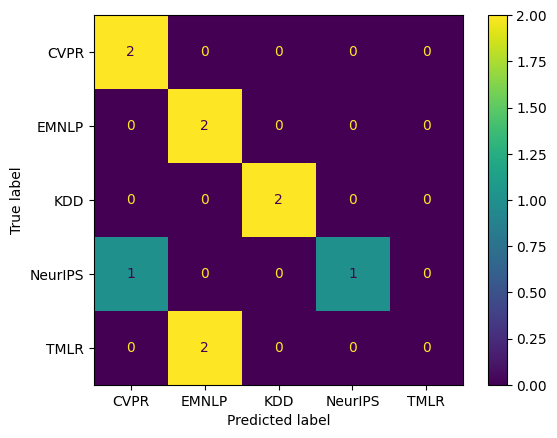


✅ Model saved to /content/conference_classification_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 3: Full Fine-Tune Transformer Model for Conference Classification

import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ✅ 1. Load Preprocessed Dataset
preprocessed_conference_path = '/content/preprocessed_conference_dataset.csv'
df_conference = pd.read_csv(preprocessed_conference_path)

print("\n✅ Preprocessed Conference Dataset Loaded. Overview:")
print(df_conference.head())

# ✅ 2. Encode Conference Labels
label_encoder = LabelEncoder()
df_conference['conference_label'] = label_encoder.fit_transform(df_conference['conference'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\n✅ Label Mapping:")
print(label_mapping)

# ✅ 3. Handle Class Imbalance with Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_conference['conference_label']),
    y=df_conference['conference_label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')
print("\n✅ Adjusted Class Weights:", class_weights)

# ✅ 4. Prepare Dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ConferenceDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts.tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt'
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

dataset = ConferenceDataset(df_conference['content'], df_conference['conference_label'])
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# ✅ 5. Load Transformer Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ✅ 6. Optimizer, Scheduler, and Loss Function
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
num_training_steps = len(data_loader) * 10  # 10 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# ✅ 7. Early Stopping Mechanism
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("\n🛑 Early stopping triggered!")
                return True
        return False

early_stopping = EarlyStopping(patience=3)

# ✅ 8. Training Function
def train_model(model, data_loader, optimizer, scheduler, loss_function, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        print(f'\n🔄 Epoch {epoch + 1}/{epochs}')
        total_loss = 0
        loop = tqdm(data_loader, leave=True)
        for batch in loop:
            optimizer.zero_grad()
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            loss = loss_function(outputs.logits, batch['labels'])
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(data_loader)
        print(f"\n✅ Average Loss for Epoch {epoch + 1}: {avg_loss:.4f}")

        if early_stopping(avg_loss):
            break

# ✅ 9. Evaluation Function
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in data_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)

    print("\n📊 Evaluation Metrics:")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot()
    plt.show()

# ✅ 10. Train and Evaluate Model
train_model(model, data_loader, optimizer, scheduler, loss_function, device)
evaluate_model(model, data_loader, device)

# ✅ 11. Save Model
model_save_path = '/content/conference_classification_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"\n✅ Model saved to {model_save_path}")

# ✅ 12. Download Model
from google.colab import files
files.download(model_save_path)


In [ ]:
import os

# Check for the model file in the content directory
print("📂 Listing all files in /content:")
os.listdir('/content')


📂 Listing all files in /content:


['.config',
 'P001.pdf',
 'P055 (1).pdf',
 'P097 (2).pdf',
 'P039 (1).pdf',
 'P086.pdf',
 'P046.pdf',
 'P109.pdf',
 'P017.pdf',
 'P042 (1).pdf',
 'P015 (1).pdf',
 'P057 (2).pdf',
 'P027 (2).pdf',
 'P115 (2).pdf',
 'P001 (2).pdf',
 'R009 (2).pdf',
 'test_dataset_preprocessed.csv',
 'P078 (2).pdf',
 'P092.pdf',
 'P074 (2).pdf',
 'P101 (2).pdf',
 'R013 (4).pdf',
 'P104.pdf',
 'P024 (1).pdf',
 'R005.pdf',
 'P065.pdf',
 'P100 (1).pdf',
 'P134 (2).pdf',
 'P098 (1).pdf',
 'P002.pdf',
 'P033.pdf',
 'P121 (2).pdf',
 'P119 (2).pdf',
 'R006.pdf',
 'P114 (2).pdf',
 'P043.pdf',
 'P061.pdf',
 'P071 (1).pdf',
 'P041.pdf',
 'P040.pdf',
 'P117 (2).pdf',
 'P021 (1).pdf',
 'P005 (1).pdf',
 'P110 (1).pdf',
 'final_test_classification_results.csv',
 'R007 (4).pdf',
 'P127 (1).pdf',
 'R002.pdf',
 'P028 (1).pdf',
 'P014 (2).pdf',
 'P062.pdf',
 'P035.pdf',
 'P066.pdf',
 'P056 (2).pdf',
 'P026 (2).pdf',
 'P093.pdf',
 'P055 (2).pdf',
 'test_dataset (4).csv',
 'R014 (2).pdf',
 'P018.pdf',
 'P088.pdf',
 'P060 (2)

In [ ]:
torch.save(model.state_dict(), '/content/publishability_model.pth')


In [ ]:
# Skip model loading if already in memory
print("\n✅ Using the Publishability Model already in memory.")



✅ Using the Publishability Model already in memory.


In [ ]:
# Step 4.1: Reclassify Test Dataset for Publishability (With Model Upload Option)

import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from google.colab import files
import re
import os

# ✅ 1. Upload Publishability Transformer Model (if not available)
model_path = '/content/publishability_transformer_model.pth'

if not os.path.exists(model_path):
    print("\n📤 Upload the Publishability Transformer Model (e.g., .pth file):")
    uploaded_model = files.upload()
    model_file = list(uploaded_model.keys())[0]
    model_path = f"/content/{model_file}"
    print(f"\n✅ Model uploaded and saved as: {model_path}")
else:
    print("\n✅ Publishability Transformer Model Found in Environment.")

# ✅ 2. Upload Test Dataset
print("\n📤 Upload the Test Dataset (CSV format with 'paper_id' and 'content' columns):")
uploaded_test = files.upload()
test_file = list(uploaded_test.keys())[0]
test_path = f"/content/{test_file}"

# ✅ 3. Load the Dataset
df_test = pd.read_csv(test_path)
print("\n✅ Test Dataset Loaded. Overview:")
print(df_test.head())

# ✅ 4. Verify Required Columns
if 'content' not in df_test.columns or 'paper_id' not in df_test.columns:
    raise ValueError("The dataset must have 'content' and 'paper_id' columns!")

# ✅ 5. Preprocess Text Data
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_test['content'] = df_test['content'].apply(preprocess_text)

# ✅ 6. Load Pretrained Publishability Model
publishability_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
publishability_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
publishability_model.to(device)

# ✅ 7. Load Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# ✅ 8. Classify Papers for Publishability
def classify_publishability(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = publishability_model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return 'Publishable' if prediction == 1 else 'Non-Publishable'

print("\n⚙️ Classifying Papers for Publishability...")
df_test['publishable'] = df_test['content'].apply(classify_publishability)

# ✅ 9. Filter Only "Publishable" Papers
df_publishable = df_test[df_test['publishable'] == 'Publishable'].copy()
print("\n✅ Filtered Publishable Papers:")
print(df_publishable.head())
print(f"\n✅ Total Publishable Papers: {len(df_publishable)}")

# ✅ 10. Save Filtered Dataset
publishable_test_path = '/content/publishable_test_dataset.csv'
df_publishable[['paper_id', 'content']].to_csv(publishable_test_path, index=False)
print(f"\n✅ Publishable Test Dataset saved to: {publishable_test_path}")

# ✅ 11. Enable Download
print("\n📥 Click below to download the Publishable Test Dataset CSV:")
files.download(publishable_test_path)



✅ Publishability Transformer Model Found in Environment.

📤 Upload the Test Dataset (CSV format with 'paper_id' and 'content' columns):


Saving test_dataset.csv to test_dataset (7).csv

✅ Test Dataset Loaded. Overview:
  paper_id                                            content
0  paper_1  Leveraging Clustering Techniques for Enhanced\...
1  paper_2  Virus Propagation and their Far-Reaching\nImpl...
2  paper_3  Explainable Reinforcement Learning for Financi...
3  paper_4  Graph Neural Networks Without Training: Harnes...
4  paper_5  Collaborative Clothing Segmentation and\nIdent...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-64-1df20881d476>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec


⚙️ Classifying Papers for Publishability...

✅ Filtered Publishable Papers:
  paper_id                                            content  publishable
0  paper_1  leveraging clustering techniques for enhanced ...  Publishable
2  paper_3  explainable reinforcement learning for financi...  Publishable
3  paper_4  graph neural networks without training harness...  Publishable
4  paper_5  collaborative clothing segmentation and identi...  Publishable
6  paper_7  joint syntactodiscourse parsing and the syntac...  Publishable

✅ Total Publishable Papers: 97

✅ Publishable Test Dataset saved to: /content/publishable_test_dataset.csv

📥 Click below to download the Publishable Test Dataset CSV:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 4.2: Classify Publishable Papers into Conferences

import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import re
from google.colab import files

# ✅ 1. Verify the Publishable Dataset from Previous Step
print("\n✅ Using Filtered Publishable Papers Dataset from Previous Step:")
print(df_publishable.head())

# ✅ 2. Ensure Required Columns Exist
if 'content' not in df_publishable.columns or 'paper_id' not in df_publishable.columns:
    raise ValueError("The dataset must have 'content' and 'paper_id' columns!")

print(f"\n✅ Total Publishable Papers: {len(df_publishable)}")

# ✅ 3. Preprocess Text Data
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_publishable['content'] = df_publishable['content'].apply(preprocess_text)

# ✅ 4. Load Fine-Tuned Conference Classification Model
model_path = '/content/conference_classification_model.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ✅ 5. Load Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# ✅ 6. Load Label Encoder for Conference Classes
conference_classes = ['TMLR', 'NeurIPS', 'KDD', 'EMNLP', 'CVPR']
label_encoder = LabelEncoder()
label_encoder.fit(conference_classes)

# ✅ 7. Classify Papers and Generate Rationales
def classify_paper(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    predicted_conference = label_encoder.inverse_transform([prediction])[0]
    return predicted_conference

def generate_rationale(text, conference):
    return f"This paper aligns with the key themes and focus areas of {conference}, making it an appropriate venue for submission based on its content and findings."

print("\n⚙️ Classifying Papers and Generating Rationales...")
df_publishable['conference'] = df_publishable['content'].apply(classify_paper)
df_publishable['rationale'] = df_publishable.apply(
    lambda row: generate_rationale(row['content'], row['conference']), axis=1
)

# ✅ 8. Display Sample Results
print("\n✅ Sample Classified Papers with Rationales:")
print(df_publishable.head())

# ✅ 9. Save Final Results
final_results_path = '/content/publishable_conference_classification_results.csv'
df_publishable[['paper_id', 'content', 'conference', 'rationale']].to_csv(final_results_path, index=False)
print(f"\n✅ Final classification results saved to: {final_results_path}")

# ✅ 10. Enable Download
print("\n📥 Click below to download the final classification results CSV:")
files.download(final_results_path)



✅ Using Filtered Publishable Papers Dataset from Previous Step:
  paper_id                                            content  publishable  \
0  paper_1  leveraging clustering techniques for enhanced ...  Publishable   
2  paper_3  explainable reinforcement learning for financi...  Publishable   
3  paper_4  graph neural networks without training harness...  Publishable   
4  paper_5  collaborative clothing segmentation and identi...  Publishable   
6  paper_7  joint syntactodiscourse parsing and the syntac...  Publishable   

  conference                                          rationale  
0       TMLR  This paper aligns with the key themes and focu...  
2    NeurIPS  This paper aligns with the key themes and focu...  
3    NeurIPS  This paper aligns with the key themes and focu...  
4       CVPR  This paper aligns with the key themes and focu...  
6      EMNLP  This paper aligns with the key themes and focu...  

✅ Total Publishable Papers: 97


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-66-d12f38c8ed51>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec


⚙️ Classifying Papers and Generating Rationales...

✅ Sample Classified Papers with Rationales:
  paper_id                                            content  publishable  \
0  paper_1  leveraging clustering techniques for enhanced ...  Publishable   
2  paper_3  explainable reinforcement learning for financi...  Publishable   
3  paper_4  graph neural networks without training harness...  Publishable   
4  paper_5  collaborative clothing segmentation and identi...  Publishable   
6  paper_7  joint syntactodiscourse parsing and the syntac...  Publishable   

  conference                                          rationale  
0       TMLR  This paper aligns with the key themes and focu...  
2    NeurIPS  This paper aligns with the key themes and focu...  
3    NeurIPS  This paper aligns with the key themes and focu...  
4       CVPR  This paper aligns with the key themes and focu...  
6      EMNLP  This paper aligns with the key themes and focu...  

✅ Final classification results saved 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install Pathway (if not installed)
!pip install pathway

# Import Libraries
import pathway as pw
from pathway.xpacks.llm.vector_store import VectorStoreServer, VectorStoreClient
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd
import re

# === Step 1: Load Dataset with Pathway Connectors ===
# Stream dataset from Google Drive (or replace with your source)
docs = pw.io.fs.read(
    "gdrive://path/to/your/dataset",
    format="binary",
    mode="streaming",
    with_metadata=True
)

# === Step 2: Define Embedding Function ===
# Load your publishability Transformer model
publishability_model_path = "/path/to/publishability_model.pth"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.load_state_dict(torch.load(publishability_model_path, map_location=torch.device('cpu')))
model.eval()

def embed_paper(text):
    """Generate embeddings using the Transformer model."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().tolist()

# === Step 3: Set Up Pathway VectorStore Server ===
server = VectorStoreServer(
    docs,
    embedder=embed_paper,
    parser=pw.xpacks.llm.parsers.ParseUtf8()
)
server.run_server(host="0.0.0.0", port=8000, threaded=True)

# === Step 4: Classify Papers for Publishability ===
def classify_paper_for_publishability(text):
    """Classify paper as Publishable or Non-Publishable."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return "Publishable" if torch.argmax(outputs.logits) == 1 else "Non-Publishable"

# === Step 5: Use VectorStore for Conference Selection ===
# Load Conference Classification Model
conference_model_path = "/path/to/conference_model.pth"
conference_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
conference_model.load_state_dict(torch.load(conference_model_path, map_location=torch.device('cpu')))
conference_model.eval()

conference_classes = ['TMLR', 'NeurIPS', 'KDD', 'EMNLP', 'CVPR']

def classify_conference(text):
    """Classify paper into a conference."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = conference_model(**inputs)
    return conference_classes[torch.argmax(outputs.logits)]

# === Step 6: Query Pathway VectorStore and Generate Results ===
client = VectorStoreClient(host="localhost", port=8000)
retrieved_docs = client.query(query="Relevant research paper content", k=5)

results = []
for doc in retrieved_docs:
    paper_content = doc['text']
    publishability = classify_paper_for_publishability(paper_content)
    if publishability == "Publishable":
        conference = classify_conference(paper_content)
        rationale = f"This paper aligns with the key themes and focus areas of {conference}."
        results.append({
            "paper_id": doc['metadata']['paper_id'],
            "content": paper_content,
            "conference": conference,
            "rationale": rationale
        })

# === Step 7: Save Results to CSV ===
results_df = pd.DataFrame(results)
results_path = "/content/publishable_conference_results.csv"
results_df.to_csv(results_path, index=False)

print(f"Results saved to: {results_path}")


# Example: Pathway connectors can replace manual file loading for dynamic streaming.
# Uncomment and adjust the following block for live streaming data:
# import pathway as pw
# docs_publishable = pw.io.fs.read(
#     '/kaggle/input/publishable/', format='binary', mode='static', with_metadata=True)
# docs_non_publishable = pw.io.fs.read(
#     '/kaggle/input/non-publishable/', format='binary', mode='static', with_metadata=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-1-f8d17bbf8110>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/publishability_model.pth'